In [1]:
import os
import cv2
import numpy as np
import zipfile
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def unzip_file(zip_path, out_path):
  if not os.path.exists(out_path):
    os.makedirs(out_path, exist_ok=True)
  try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(out_path)
  except FileNotFoundError:
        print(f"Error: Zip file not found at {zip_path}")
  except zipfile.BadZipFile:
        print(f"Error: Invalid zip file at {zip_path}")
  except Exception as e:
        print(f"An error occurred: {e}")

In [4]:
unzip_file('/content/drive/MyDrive/PS-new.zip','/content/Dataset')

In [5]:
# prompt: resize all images in datset

import os
import cv2
import numpy as np

def resize_images_in_dataset(dataset_path, target_size=(224, 224)):
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        resized_img = cv2.resize(img, target_size)
                        cv2.imwrite(img_path, resized_img)
                    else:
                        print(f"Could not read image: {img_path}")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

# Example usage
resize_images_in_dataset('/content/Dataset')

##Dataset Augmentation

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

# Define a powerful augmentation configuration
augmentation_generator = ImageDataGenerator(
    rotation_range=40,          # Increased rotation range
    width_shift_range=0.3,     # More horizontal shifting
    height_shift_range=0.3,    # More vertical shifting
    shear_range=0.3,           # Increased shearing
    zoom_range=0.3,            # More zoom variation
    horizontal_flip=True,
    vertical_flip=True,        # Added vertical flipping
    brightness_range=[0.5, 1.5],  # Wider brightness range
    channel_shift_range=50.0,  # Color channel variations
    fill_mode='reflect',       # Better edge handling
    rescale=1./255
)

In [7]:
def generate_augmented_images(image_path, output_dir, num_augmented=10):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the image
    try:
        img = Image.open(image_path).convert('RGB') # Convert to RGB to remove alpha channel if present
    except (PIL.UnidentifiedImageError, OSError) as e:
        print(f"Error opening image {image_path}: {e}")
        return
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get the base filename
    base_filename = os.path.splitext(os.path.basename(image_path))[0]

    # Generate and save augmented images
    i = 0
    for batch in augmentation_generator.flow(img_array, batch_size=1,
                                          save_to_dir=output_dir,
                                          save_prefix=f'aug_{base_filename}',
                                          save_format='jpg'):
        i += 1
        if i >= num_augmented:
            break  # Stop after generating the desired number

In [8]:
!pip install Pillow
from IPython import get_ipython
from IPython.display import display
import PIL

In [9]:
def augment_entire_directory(input_dir, output_dir, num_augmented=10):
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        if os.path.isdir(class_path):
            output_class_dir = os.path.join(output_dir, class_dir)
            os.makedirs(output_class_dir, exist_ok=True)

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    generate_augmented_images(img_path, output_class_dir, num_augmented)

# Bulk augmentation example:
input_directory = '/content/Dataset/PS-new'
output_directory = '/content/Dataset/PS-new'
augment_entire_directory(input_directory, output_directory, num_augmented=12)

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0  # More efficient than ResNet50

# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    brightness_range=[0.7, 1.3],  # Added brightness adjustment
    fill_mode='nearest',
    validation_split=0.2
)

# Create generators with larger batch size
train_generator = train_datagen.flow_from_directory(
    '/content/Dataset/PS-new',
    target_size=(224, 224),
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    '/content/Dataset/PS-new',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Use EfficientNet as base model (better performance than ResNet)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None
)

# Freeze initial layers and gradually unfreeze some
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Build model with more regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Custom learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

# Enhanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train with more epochs
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

# Save model and history
model.save('final_model.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_final.csv', index=False)

Found 3016 images belonging to 4 classes.
Found 752 images belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3088 - loss: 7.7096 - precision: 0.3164 - recall: 0.2006

48/48 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.3091 - loss: 7.7030 - precision: 0.3167 - recall: 0.2004 - val_accuracy: 0.3378 - val_loss: 6.4784 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3738 - loss: 6.4209 - precision: 0.4131 - recall: 0.2128 - val_accuracy: 0.3378 - val_loss: 5.4152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.3791 - loss: 5.3218 - precision: 0.4028 - recall: 0.1897 - val_accuracy: 0.3378 - val_loss: 4.5110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.4140 - loss: 4.3365 - precision: 0.4569 - recall: 0.1967 - val_accuracy: 0.3351 - val_loss: 3.7577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/s

48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4501 - loss: 2.6671 - precision: 0.5206 - recall: 0.2074 - val_accuracy: 0.4109 - val_loss: 2.4820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4853 - loss: 2.2906 - precision: 0.5560 - recall: 0.2684 - val_accuracy: 0.3338 - val_loss: 2.2084 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4968 - loss: 1.9971 - precision: 0.5796 - recall: 0.2894 - val_accuracy: 0.3404 - val_loss: 2.0462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5111 - loss: 1.7982 - precision: 0.6151 - recall: 0.2993 - val_accuracy: 0.3351 - val_loss: 1.8985 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/

In [11]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [12]:
val_results = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_results[1]*100:.2f}%")

# Lower learning rate for fine-tuning
fine_tune_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for a few more epochs
fine_tune_epochs = 10
history_fine = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4047 - loss: 2.4819 - precision: 0.0000e+00 - recall: 0.0000e+00
Validation Accuracy: 38.96%
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.4893 - loss: 2.3059 - val_accuracy: 0.3218 - val_loss: 2.3766 - learning_rate: 1.0000e-04
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.5013 - loss: 2.1656 - val_accuracy: 0.2912 - val_loss: 2.3016 - learning_rate: 1.0000e-04
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4825 - loss: 2.1194 - val_accuracy: 0.2606 - val_loss: 2.2187 - learning_rate: 1.0000e-04
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.4883 - loss: 2.0422 - val_accuracy: 0.2314 - val_loss: 2.2019 - learning_rate: 1.0000e-04
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5172 - loss: 1.9423 - val_accuracy: 0.3098 - val_loss: 2.2253 - learning_rate: 1.0000e-04
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5139 - loss: 1.9036

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,817,385 (48.89 MB)

 Trainable params: 4,202,464 (16.03 MB)

 Non-trainable params: 209,991 (820.28 KB)

 Optimizer params: 8,404,930 (32.06 MB)

##Accuracy Visualization

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step


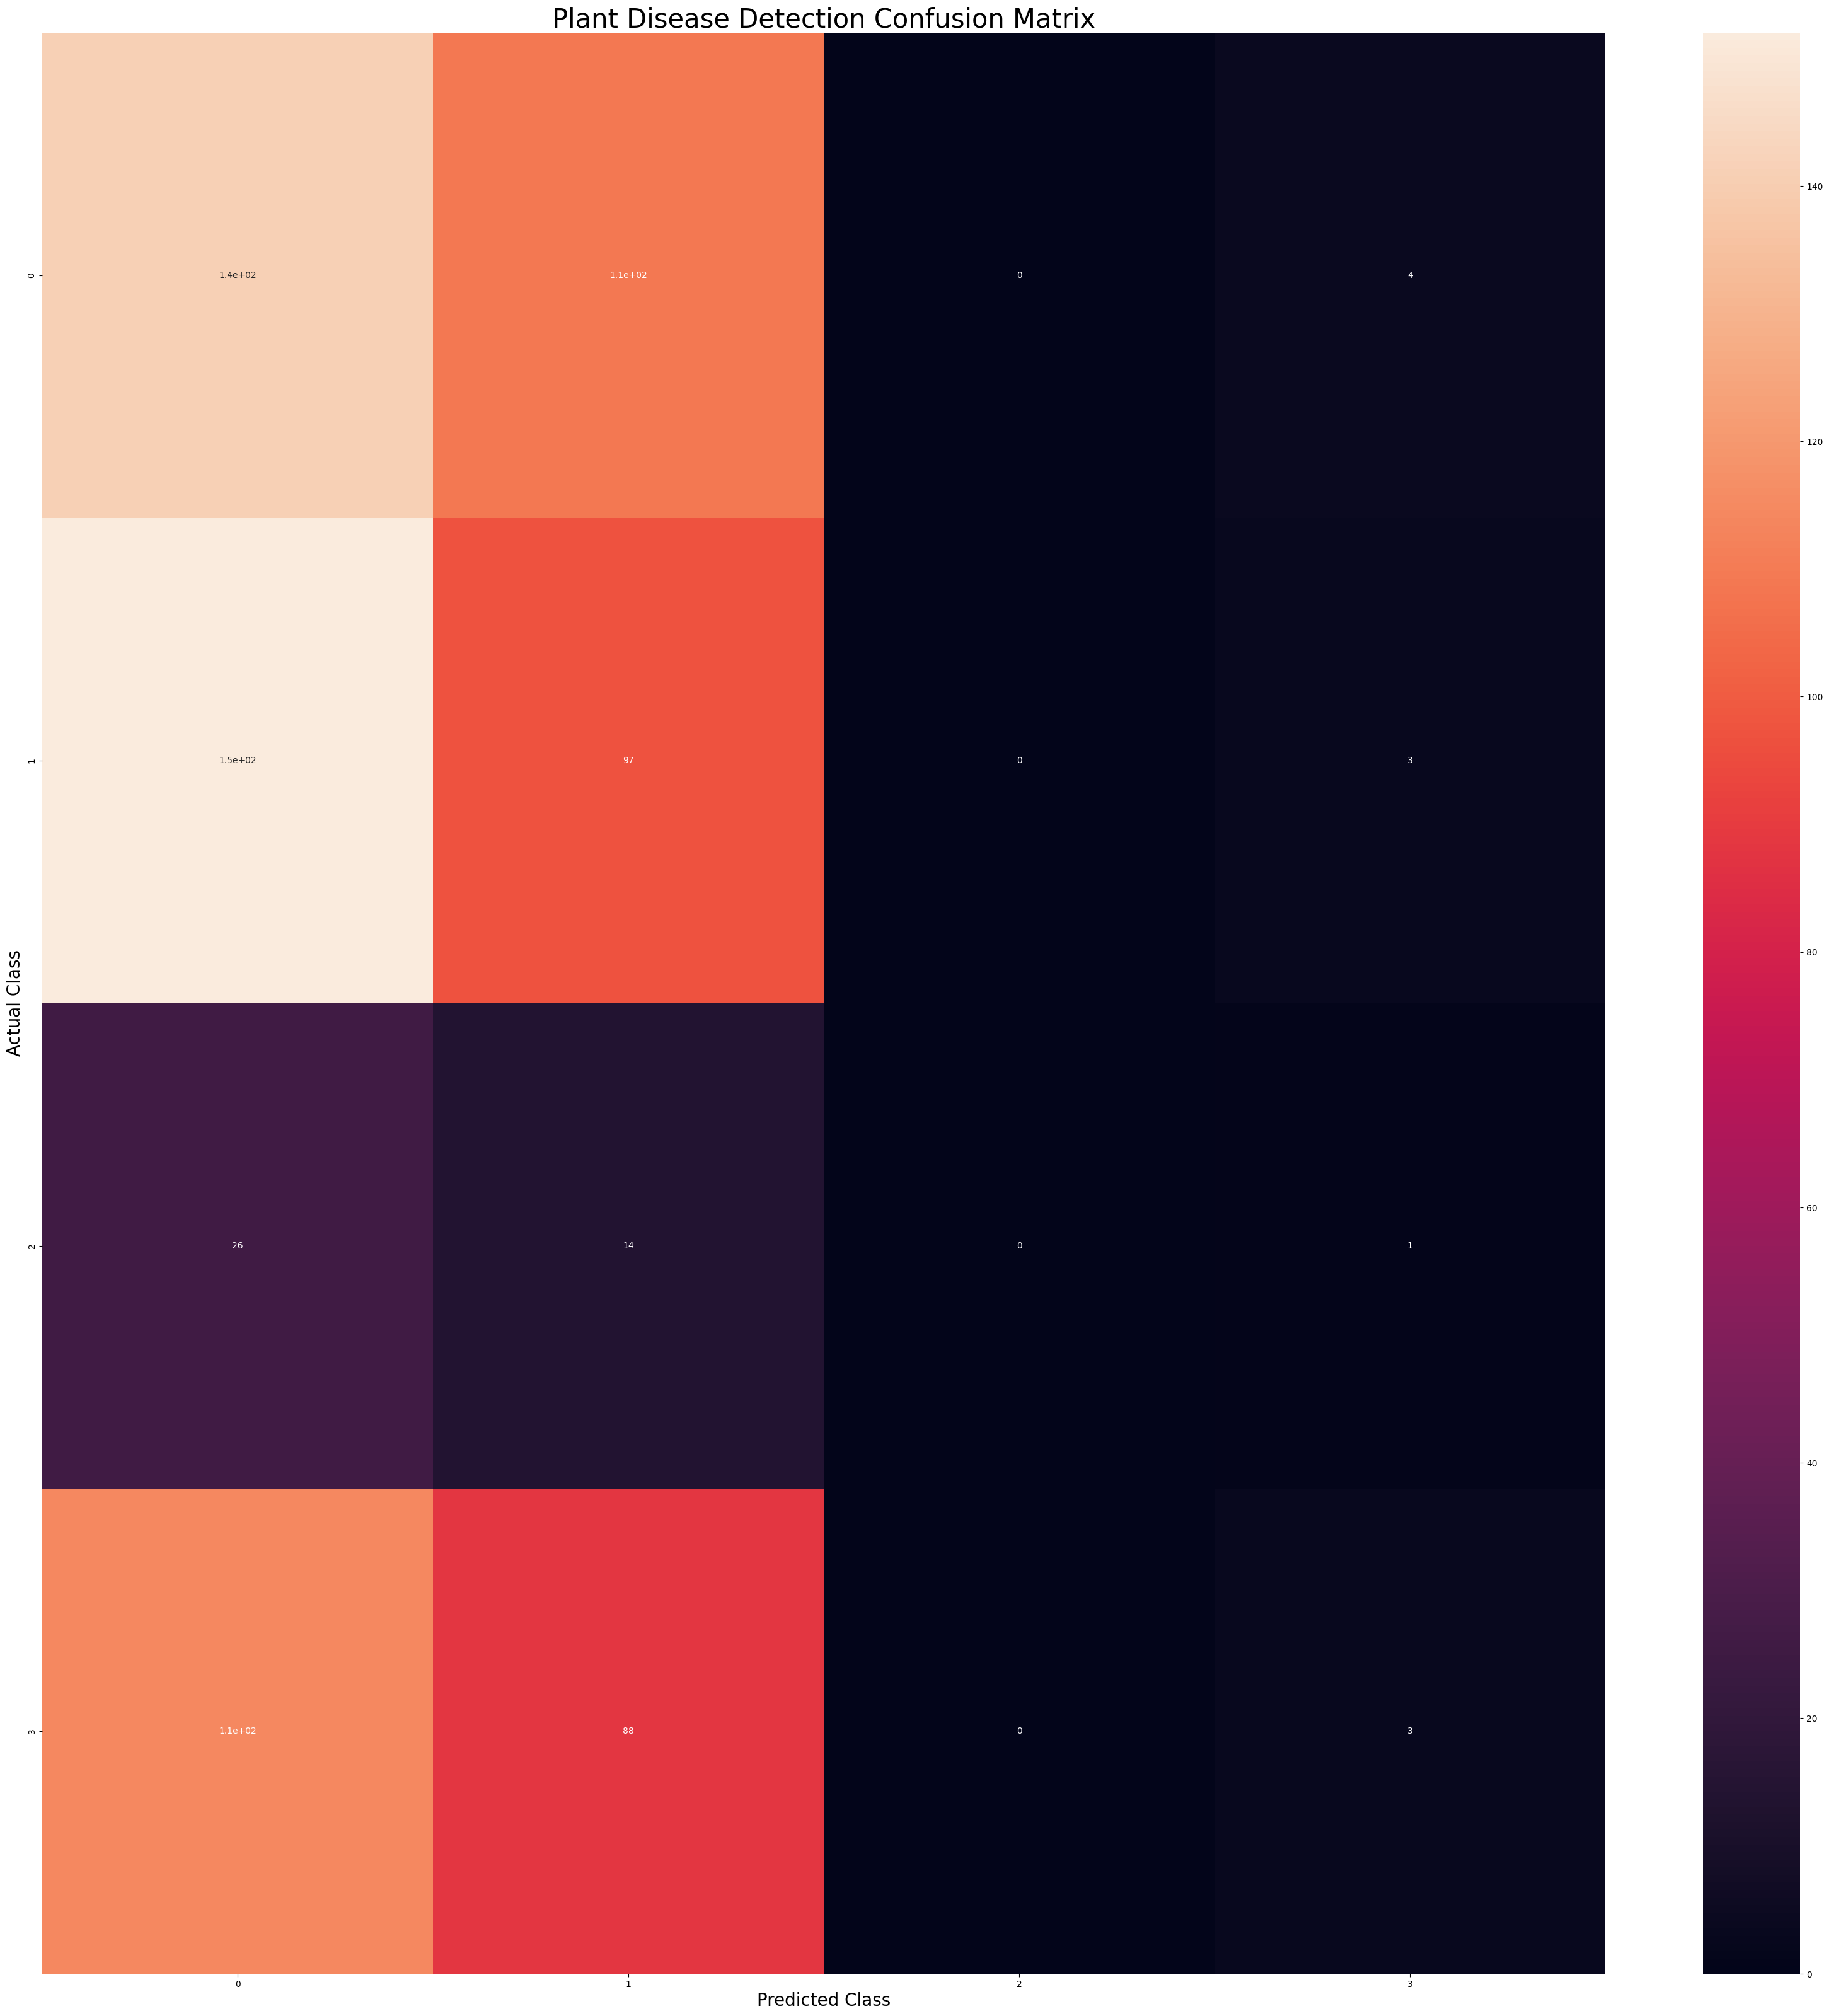

In [17]:
!pip install seaborn
import seaborn as sns
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
from sklearn.metrics import classification_report, confusion_matrix
plt.figure(figsize=(40,40))
sns.heatmap(cm,annot=True,annot_kws={'size':10})
plt.xlabel('Predicted Class',fontsize=20)
plt.ylabel('Actual Class',fontsize=20)
plt.title('Plant Disease Detection Confusion Matrix',fontsize=30)
plt.show()